In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# Import Data

In [7]:
df = pd.read_csv("data/parenting_dataset.csv", index_col="NO")
df.drop(columns=["Responden"], inplace=True)
df

,AE1,AE2,AE3,AE4,AE5,AE6,AE7,AE8,AE9,AE10,...,PE2,PE3,PE4,PE5,PE6,PE7,PE8,PE9,PE10,Parenting_style
NO,,,,,,,,,,,,,,,,,,,,,
1,4,2,3,1,2,3,3,3,3,3,...,4,3,1,4,1,2,4,1,1,Authoration
2,4,3,4,5,4,4,5,2,3,5,...,2,3,2,3,4,3,2,2,1,Authorative
3,4,4,4,5,4,4,5,3,1,1,...,4,3,4,4,4,4,4,3,3,Authorative
4,1,3,2,4,2,3,5,3,1,3,...,5,2,4,3,3,3,5,5,4,Permissive
5,3,4,5,4,3,4,5,3,4,5,...,5,1,4,3,4,3,4,4,3,Authorative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,4,2,5,2,3,1,3,1,5,2,...,2,5,3,2,4,1,4,1,5,Authoration
497,5,4,3,5,3,4,2,3,4,4,...,5,1,2,4,3,3,4,3,4,Permissive
498,1,2,3,3,2,1,4,1,2,5,...,4,4,5,1,4,5,4,5,5,Permissive


In [9]:
df.Parenting_style.value_counts()

Authorative    220
Authoration    148
Permissive     132
Name: Parenting_style, dtype: int64

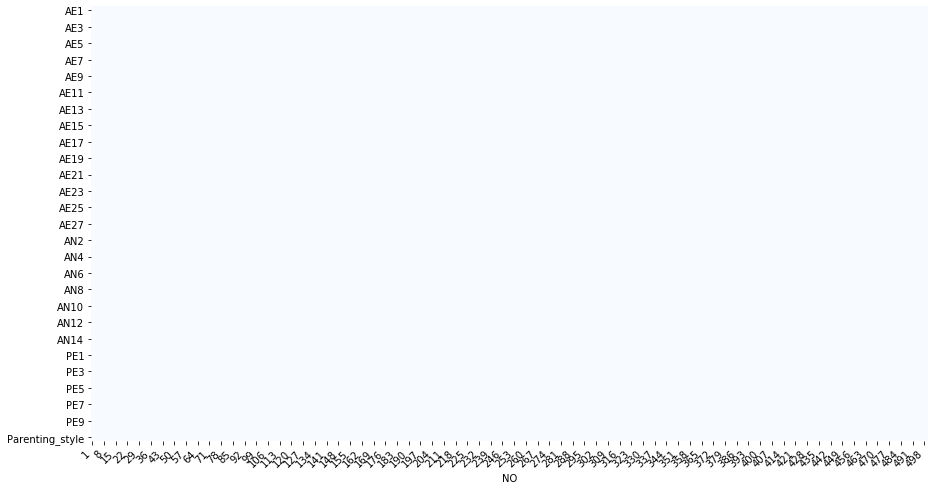

In [8]:
plot_missing_value(df) #cek data bolong / missing value

# Dataset Splitting

In [10]:
# untuk regresion memakai Stratiffied shuffle split saja

In [11]:
X = df.drop(columns="Parenting_style") #data target atau label nya adalah clas yaitu curang atau tidak curang
y = df.Parenting_style

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 52), (100, 52), (400,), (100,))

# Training

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [13]:
X_train.head() #mengecek data apakah numeric atau categoric

,AE1,AE2,AE3,AE4,AE5,AE6,AE7,AE8,AE9,AE10,...,PE1,PE2,PE3,PE4,PE5,PE6,PE7,PE8,PE9,PE10
NO,,,,,,,,,,,,,,,,,,,,,
256,5,1,5,5,5,5,1,4,2,4,...,4,2,4,2,1,5,1,5,4,3
420,1,5,4,3,4,2,2,4,2,5,...,3,3,2,3,5,5,3,4,3,2
123,5,2,4,2,3,3,3,3,4,3,...,4,3,3,3,4,4,3,3,3,4
200,2,2,3,2,2,2,2,2,2,2,...,4,4,2,4,4,4,4,3,2,3
465,1,4,2,2,5,2,1,5,3,4,...,3,3,3,3,1,3,3,5,3,4


In [14]:
gsp.svm_params

{'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [17]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), X_train.columns), #jangan lupa scalling ya, karena semua data numeric gaada pake categoric jadi dibuang aja categoric nya
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s


{'algo__C': 1.0, 'algo__gamma': 0.01}
0.92 0.7348969438521676 0.76


[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    3.1s finished


### WOW 99% test score. Ingat setiap kali mendapatkan score setinggi itu, kita harus curiga dan cek kembali

- apakah terjadi data leakage
- apakah dataset imbalance
- apakah memang problemnya sesuatu yang sederhana

Pada kasus ini sebenarnya kita imbalance

In [9]:
#dapat kita lihat pada data classnya terjadi imbalance jumlah curang dan tidak curang / imbalance dataset
df.Class.value_counts()

0    30000
1      492
Name: Class, dtype: int64

In [10]:
#terdapat base line yang sangat jauh beda
30000 / 30492 #accuracy sangat gila sekali wkwkw

0.9838646202282566

In [ ]:
#Kalau data sudah imbalance seperti ini maka jangan pakai metrik nya accuracy / jangan pakai scoring akurasi karna nanti kita bisa terkecoh alias kena tipu

# Akurasi tidak bisa dipakai untk imbalance dataset

By default kita tidak boleh pakai akurasi sebagai metrik ketika datanya imbalance. Pakailah F1 score.
Penjelasan mengenal metrik akan kita bahas lebih lanjut di materi selanjutnya,
Untuk sekarang gunakanlah scoring='f1'

In [43]:
gsp.rf_params

{'algo__n_estimators': [100, 150, 200],
 'algo__max_depth': [20, 50, 80],
 'algo__max_features': [0.3, 0.6, 0.8],
 'algo__min_samples_leaf': [1, 5, 10]}

In [50]:
from sklearn.ensemble import RandomForestClassifier
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns), #jangan lupa scalling ya, karena semua data numeric gaada pake categoric jadi dibuang aja categoric nya
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   19.6s finished


{'algo__max_depth': 20, 'algo__max_features': 0.3, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 150}
1.0 0.7752154670393665 0.725


In [ ]:
model = Sequential()

model.add(Dense(10, input_shape=(4,), activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Adam optimizer with learning rate of 0.001
optimizer = Adam(lr=0.001)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print('Neural Network Model Summary: ')
print(model.summary())

# Train the model
model.fit(train_x, train_y, verbose=2, batch_size=5, epochs=200)

In [48]:
from jcopml.plot import plot_confusion_matrix

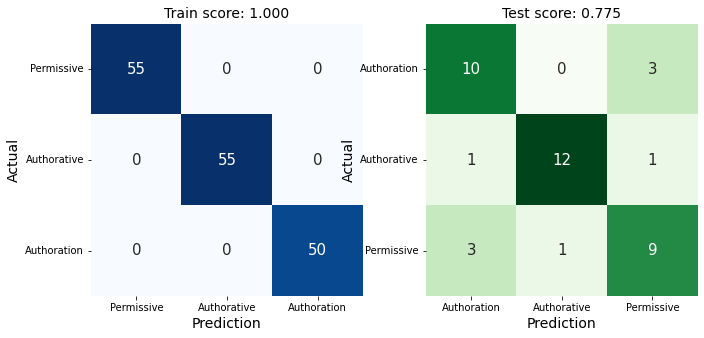

In [52]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

# Coba  improve pakai class weight

In [30]:
# buat dictionary dulu dan kita tuning datanya satu satu
[
    {0: 0.05, 1: 0.95},
    {0: 0.1, 1: 0.9},
    {0: 0.25, 1: 0.25}
]

# weights params nya bisa kita looping ajaa jadi code nya bisa diubah seperti code dibawah

[{0: x, 1: 1-x} for x in [0.05, 0.1, 0.25]]

[{0: 0.05, 1: 0.95}, {0: 0.1, 1: 0.9}, {0: 0.25, 1: 0.75}]

In [31]:
gsp.svm_params

{'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [34]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), X_train.columns), #jangan lupa scalling ya, karena semua data numeric gaada pake categoric jadi dibuang aja categoric nya
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

#membuat parameter sendiri, tidak memakai rekomendasi parameter menurut sebelumnya yang pak wira ajarkan
parameter = {
    'algo__gamma': np.logspace(-3, 3, 7),
    'algo__C': np.logspace(-3, 3, 7),
    'algo__class_weight': [{0: x, 1: 1-x} for x in [0.05, 0.1, 0.25]]
}

model = GridSearchCV(pipeline, parameter, cv=3, n_jobs=-1, verbose=1) #jangan lupa juga untuk mengganti jadi parameter bukan gsp.parameterygdisarankan lagi
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 147 candidates, totalling 441 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 441 out of 441 | elapsed:    3.7s finished


TypeError: '<' not supported between instances of 'str' and 'int'